In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sts

import pystan

In [2]:
df = pd.read_csv('socialmobility.csv')
df

,father,son,count
0,farm,farm,703
1,farm,unskilled,1478
2,farm,skilled,1430
3,farm,professional,1109
4,unskilled,farm,58
5,unskilled,unskilled,1756
6,unskilled,skilled,1630
7,unskilled,professional,1568
8,skilled,farm,63
9,skilled,unskilled,1453


There are 16 categories, we can start with uniform Dirichlet distribution over $\vec{p}$ with $\vec{\alpha} = (1, \cdots, 1)$.

$$Dirichlet(p_{1}, p_{2}, \cdots, p_{16}) | (1, 1, \cdots, 1)$$

Given that info, we know that the Dirichlet distribution is a conjugate prior for our Multinomial distribution. Therefore the posterior is also a Dirichlet distribution. 
The new alpha is given as $\vec{\alpha_{p\text{post}}} = \vec{\alpha_{\text{prior}}} + \vec{x}$

In [3]:
df['posterior'] = df['count'] + 1
df

,father,son,count,posterior
0,farm,farm,703,704
1,farm,unskilled,1478,1479
2,farm,skilled,1430,1431
3,farm,professional,1109,1110
4,unskilled,farm,58,59
5,unskilled,unskilled,1756,1757
6,unskilled,skilled,1630,1631
7,unskilled,professional,1568,1569
8,skilled,farm,63,64
9,skilled,unskilled,1453,1454


In [4]:
df.loc[df['father'] == 'unskilled']

,father,son,count,posterior
4,unskilled,farm,58,59
5,unskilled,unskilled,1756,1757
6,unskilled,skilled,1630,1631
7,unskilled,professional,1568,1569


The `unskilled_skilled` category with index 6 at position 2 represents the situation whereby the father was unskilled and their son was skilled. To calculate the 95% probability of this situaion we use `numpy`.

In [5]:
samples_1 = sts.dirichlet.rvs(list(df.loc[df['father'] == 'unskilled']['posterior']), size=10000)
samples_1

array([[0.01106683, 0.34645241, 0.32544745, 0.31703331],
       [0.01312141, 0.34906343, 0.3185286 , 0.31928657],
       [0.01200244, 0.35687034, 0.32258678, 0.30854044],
       ...,
       [0.01128939, 0.35872593, 0.32680765, 0.30317704],
       [0.01070704, 0.34433493, 0.31960285, 0.32535518],
       [0.01055765, 0.33839927, 0.33159214, 0.31945094]])

Getting only the `farm` values whereby the father was a farmer. The index of when the child is `skilled` is 2. Therefore we would calculate the dirichlet of index 2.

In [6]:
percentiles = np.percentile(samples_1[:, 2], [2.5, 97.5])

print(f"95% confidence interval = {percentiles}")

95% confidence interval = [0.31200806 0.33808833]


Doing the same thing for a father that works on the farm and their son works as a professional `farm_professional` index 3

In [7]:
df.loc[df['father'] == 'farm']

,father,son,count,posterior
0,farm,farm,703,704
1,farm,unskilled,1478,1479
2,farm,skilled,1430,1431
3,farm,professional,1109,1110


In [8]:
samples_2 = sts.dirichlet.rvs(list(df.loc[df['father'] == 'farm']['posterior']), size=10000)
samples_2

array([[0.14091224, 0.31446584, 0.30177655, 0.24284537],
       [0.15314417, 0.3076781 , 0.30600138, 0.23317634],
       [0.15071806, 0.31712559, 0.30745668, 0.22469967],
       ...,
       [0.1603102 , 0.30825725, 0.2979399 , 0.23349265],
       [0.1470923 , 0.30712419, 0.31422539, 0.23155812],
       [0.15397158, 0.30874266, 0.30031758, 0.23696818]])

In [9]:
percentiles = np.percentile(samples_2[:, 3],  [2.5, 97.5])

print(f"95% confidence interval = {percentiles}")

95% confidence interval = [0.22293175 0.24720068]


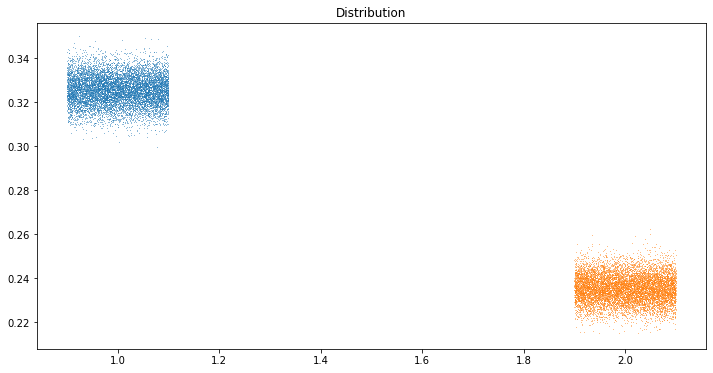

In [10]:
to_plot = []
samples = [samples_1[:, 2], samples_2[:, 3]]
plt.figure(figsize=(12, 6))
for i in range(2):
    y = samples[i]
    plt.plot(sts.uniform.rvs(loc=i+1-0.1, scale=0.2, size=len(y)), y, ',', alpha=0.5)
plt.title('Distribution')
plt.show()

In [11]:
# Code the type of work with integers
farm = 0
unskilled = 1
skilled = 2
professional = 3

# Matrix of counts such that, for example, counts[farm][skilled] is the
# number of times a father does farm work and a son skilled work.
counts = [
    [703, 1478, 1430, 1109],
    [58, 1756, 1630, 1568],
    [63, 1453, 2068, 2483],
    [61, 749, 1183, 3315]]

In [12]:
# This is a partial Stan model. Look up how to define the multinomial
# and dirichlet distributions in your likelihood and prior.

stan_code = '''

data {
    int<lower=1> C;    // number of categories in the multinomial
    vector[C] alpha;   // prior hyperparameters for Dirichlet
    int counts[C];     // the data set: counts for each category
}

parameters {
    simplex[C] theta;  // the probability vector over categories
}

model {
    theta ~ dirichlet(alpha);
    counts ~ multinomial(theta);
}
'''

stan_model = pystan.StanModel(model_code=stan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_f51709e4eef7fbe9d0fba9efc1b42b34 NOW.


In [13]:
# Results for one row (father = 0)
stan_data = {
    'C': 4,
    'alpha': [1, 1, 1, 1],
    'counts': counts[0]}
results = stan_model.sampling(data=stan_data)
print(results)

Inference for Stan model: anon_model_f51709e4eef7fbe9d0fba9efc1b42b34.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
theta[1]   0.15  7.6e-5 5.1e-3   0.14   0.15   0.15   0.15   0.16   4523    1.0
theta[2]   0.31  1.0e-4 6.8e-3    0.3   0.31   0.31   0.32   0.33   4256    1.0
theta[3]    0.3  1.0e-4 6.8e-3   0.29    0.3    0.3   0.31   0.32   4403    1.0
theta[4]   0.23  8.7e-5 6.0e-3   0.22   0.23   0.23   0.24   0.25   4757    1.0
lp__      -6375    0.03   1.18  -6378  -6376  -6375  -6374  -6374   2156    1.0

Samples were drawn using NUTS at Wed Feb 24 16:26:38 2021.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


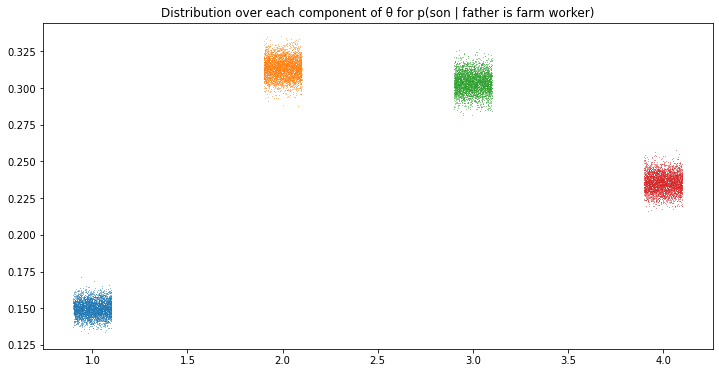

In [14]:
samples = results.extract()
plt.figure(figsize=(12, 6))
for i in range(4):
    plt.plot(sts.uniform.rvs(loc=i+1-0.1, scale=0.2, size=samples['theta'].shape[0]), samples['theta'][:,i], ',', alpha=0.5)
plt.title('Distribution over each component of θ for p(son | father is farm worker)')
plt.show()

In [15]:
stan_data = {
    'C': 4,
    'alpha': [1, 1, 1, 1],
    'counts': ...}

results = []
for i in range(4):
    stan_data['counts'] = counts[i]
    results.append(stan_model.sampling(data=stan_data))
    print(results[-1])

Inference for Stan model: anon_model_f51709e4eef7fbe9d0fba9efc1b42b34.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
theta[1]   0.15  7.7e-5 5.1e-3   0.14   0.15   0.15   0.15   0.16   4333    1.0
theta[2]   0.31  9.8e-5 6.7e-3    0.3   0.31   0.31   0.32   0.33   4673    1.0
theta[3]    0.3  8.8e-5 6.6e-3   0.29    0.3    0.3   0.31   0.32   5616    1.0
theta[4]   0.23  8.6e-5 6.1e-3   0.22   0.23   0.23   0.24   0.25   5033    1.0
lp__      -6375    0.03   1.25  -6379  -6376  -6375  -6374  -6374   1944    1.0

Samples were drawn using NUTS at Wed Feb 24 16:26:44 2021.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


Inference for Stan model: anon_model_f51709e4eef7fbe9d0fba9efc1b42b34.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
theta[1]   0.01  2.6e-5 1.5e-3 9.0e-3   0.01   0.01   0.01   0.02   3590    1.0
theta[2]   0.35  1.1e-4 6.6e-3   0.34   0.35   0.35   0.35   0.36   3739    1.0
theta[3]   0.33  1.1e-4 6.6e-3   0.31   0.32   0.32   0.33   0.34   3698    1.0
theta[4]   0.31  1.0e-4 6.4e-3    0.3   0.31   0.31   0.32   0.33   3883    1.0
lp__      -5762    0.03   1.19  -5765  -5763  -5762  -5761  -5761   2242    1.0

Samples were drawn using NUTS at Wed Feb 24 16:26:45 2021.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).
Inference for Stan model: anon_model_f51709e4eef7fbe9d0fba9efc1b42b34.
4 chains, each with iter=2000; warmup

In [16]:
# Calculate the transition matrix of the type of work a son does, conditioned on the type
# of work his father does. That is, calculate a matrix, M, such that M[i,j] is the
# probability that the son does type of work j given that the father does type of work i.

M = np.empty((4, 4))
for i, result in enumerate(results):
    samples = result.extract()
    M[i,:] = samples['theta'].mean(axis=0)
M

array([[0.14894479, 0.31324416, 0.3029574 , 0.23485366],
       [0.01180316, 0.35022234, 0.32519654, 0.31277797],
       [0.01054367, 0.23942958, 0.34081302, 0.40921373],
       [0.01167708, 0.14119821, 0.22285927, 0.62426545]])

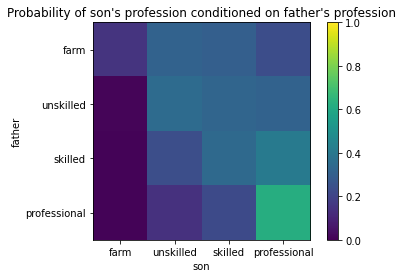

In [17]:
plt.imshow(M, vmin=0, vmax=1)
plt.xticks([0, 1, 2, 3], ['farm', 'unskilled', 'skilled', 'professional'])
plt.xlabel('son')
plt.yticks([0, 1, 2, 3], ['farm', 'unskilled', 'skilled', 'professional'])
plt.ylabel('father')
plt.title("Probability of son's profession conditioned on father's profession")
plt.colorbar()
plt.show()